In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [48]:
def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=x,rho,u
    lJ=np.zeros(x.shape[1])
    if steps==1: return x_,rho_,u_,lJ
    for n in range(steps):
        print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
    # end for
    return x_,rho_,u_,lJ

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+0.5*np.sin(2*x_+u_)+0.5)%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=x,rho,u
    lJ=-lm(rho_)
    rho_=Qm((Fm(rho_)-0.5*np.sin(2*x+u)+0.5)%1)
    lJ=lJ+lm(rho_)
    u_=(u+xi)%1
    x_,rho_=Ham(x,rho,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    for l in range(L):
        rhot = rho  + epsilon*grad_lp(x)/2
        x    = x    - epsilon*grad_lm(rhot)
        rho  = rhot + epsilon*grad_lp(x)/2
    # end for
    return x,rho

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2) #(M,d)->(d,)
def lap_Fm(rho): return 0.5+0.5*np.sign(rho)*(1-np.exp(-np.abs(rho))) #(M,d)->(M,d)
def lap_Qm(p)  : return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2

In [ ]:
# target specification
def lp(x): return gauss_lp(x,0,1)
def grad_lp(x): return -x

# ref specification
mu0=10
sigma0=0.3
def lq0(x): return gauss_lp(x,mu0,sigma0)
def randq0(size): return mu0+sigma0*np.random.randn(1,size)

ss=1000
q0_sample=randq0(ss)

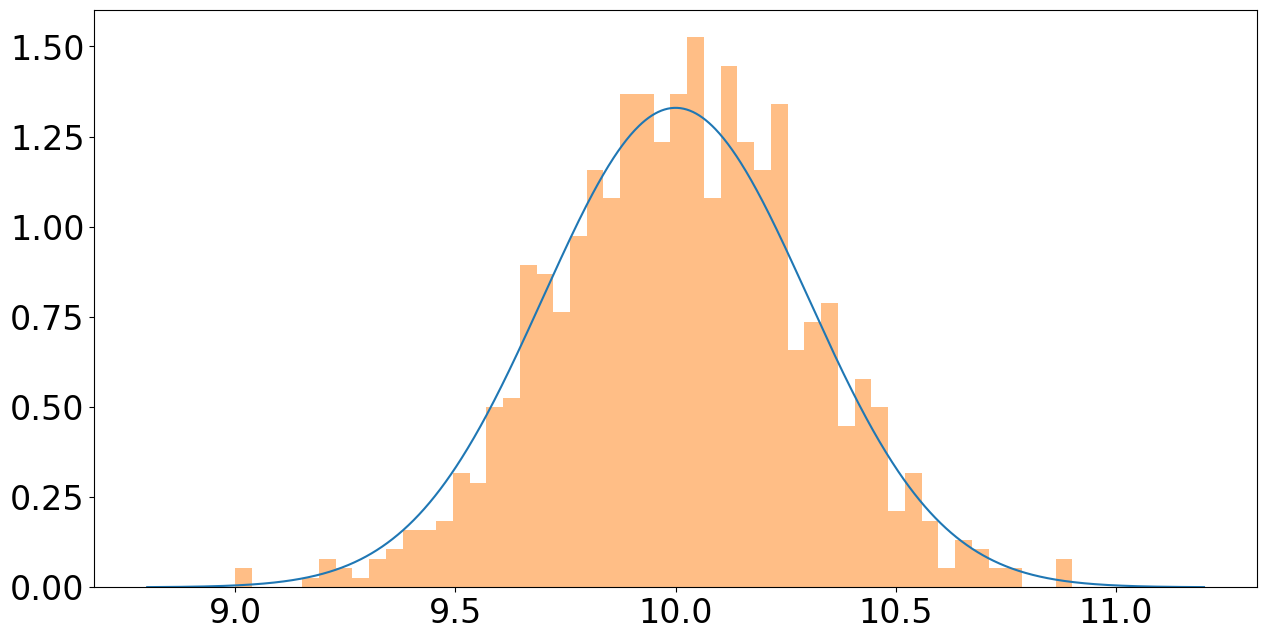

In [60]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(lq0(ttx[np.newaxis,:])))
plt.hist(q0_sample[0,:],alpha=0.5,density=True,bins=50);

## Forward pass

In [61]:
# settings
steps=10
x=q0_sample
rho=np.random.laplace(size=ss)
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16
direction='fwd'

In [62]:
xp,rhop,up,lJ=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction)

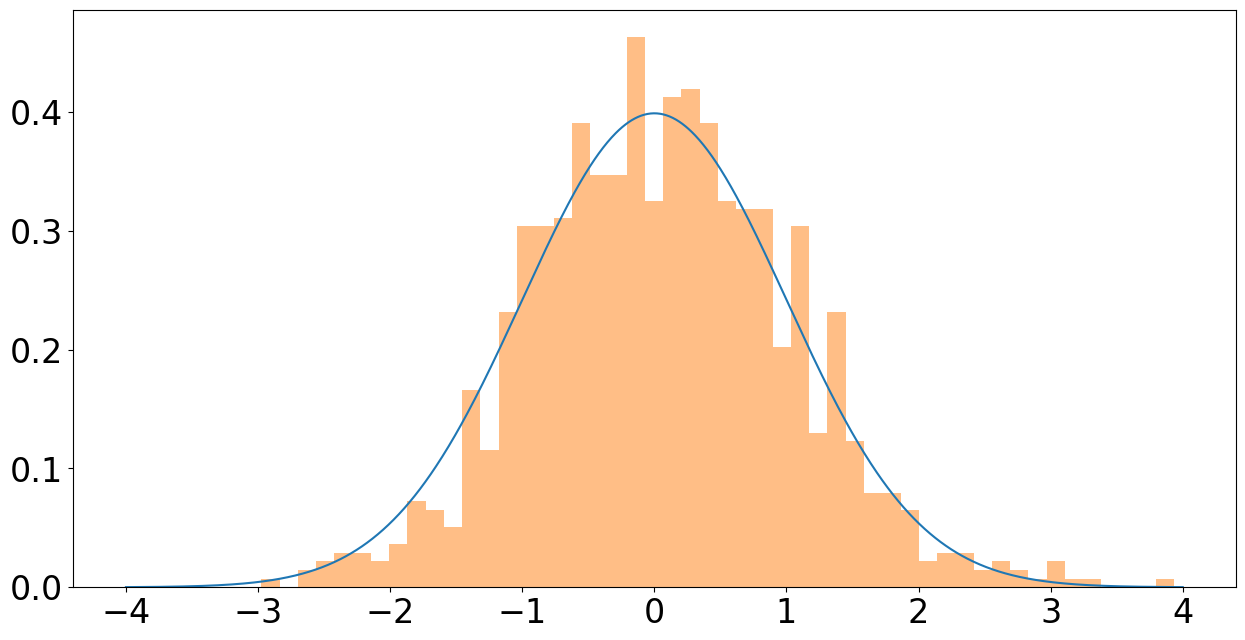

In [69]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])))
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50);

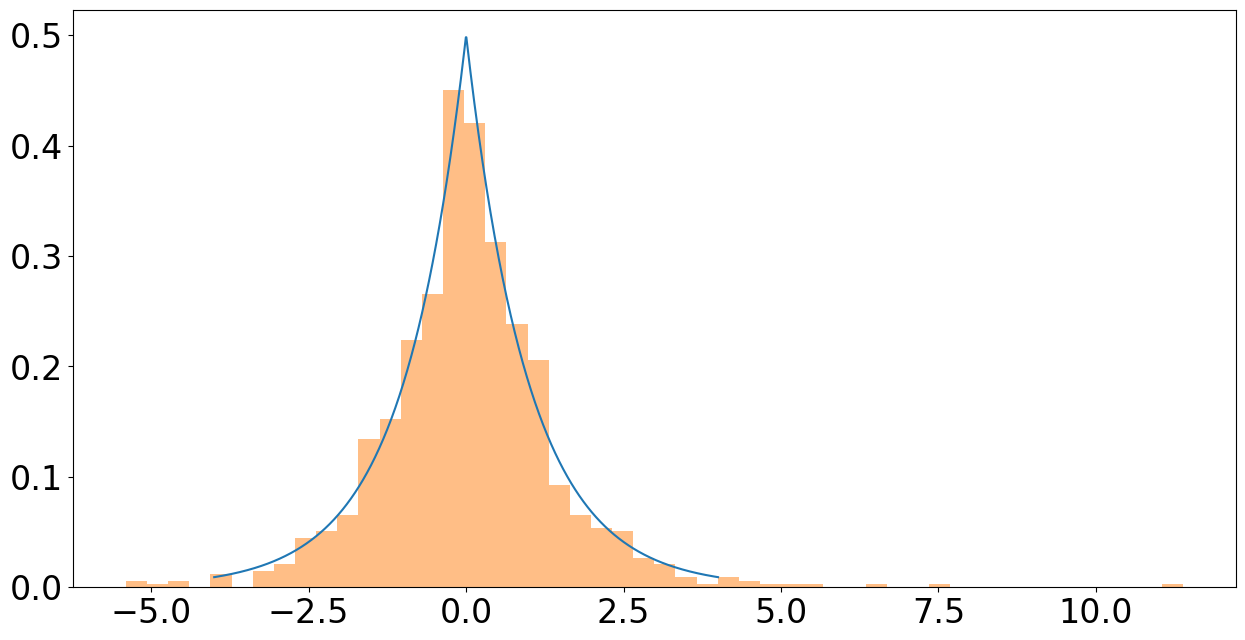

In [70]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50);

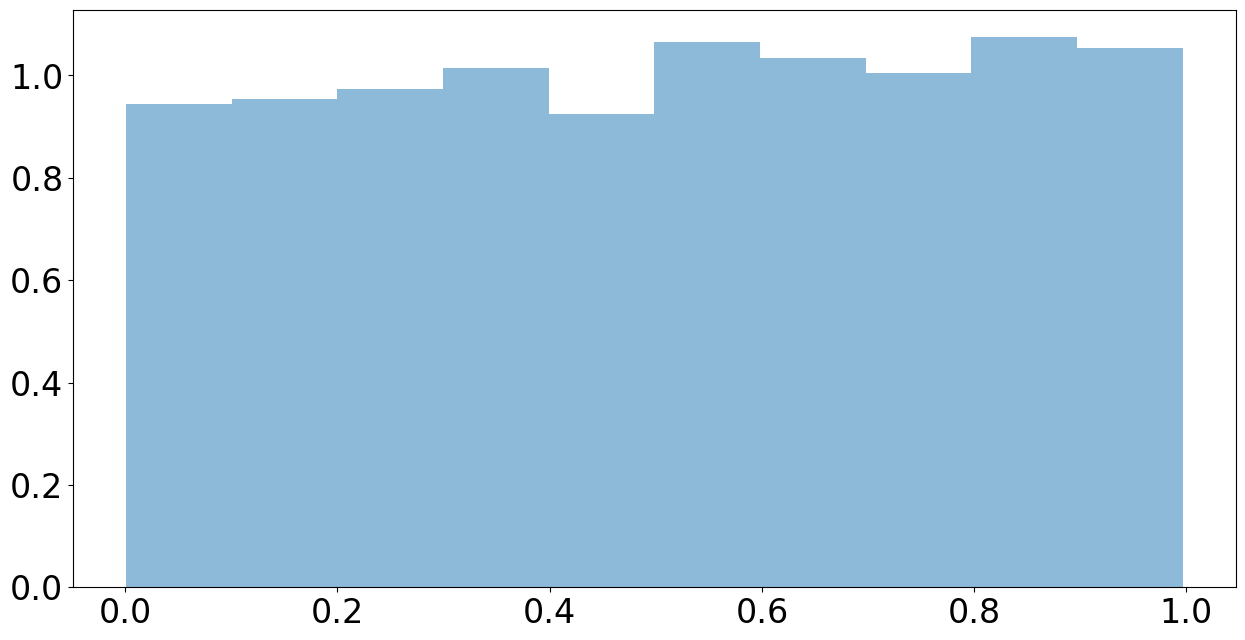

In [72]:
plt.hist(up,alpha=0.5,density=True,bins=10);

## Backward pass